<a href="https://colab.research.google.com/github/am-bean/SummerDoctoralProgram/blob/main/RegressionExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression Example


This Jupyter Notebook is a very simple case study of linear regression applied to a social science research question. The idea we want to explore is as follows:

**RQ:** Does access to the internet lead to increased acceptance of women in government?

To begin with, it is worth noting that this question is stated as a causal relationship. The methods we are using are NOT suitable for demonstrating causality. We are also not dealing with the huge number of possible confounding factors which may mediate this relationship. Doing so requires a great deal of care, and is out of the scope of this short tutorial.

## Getting Set Up


The first lines of any Python code will be imports. This allow Python to load the relevant packages (pieces of software) for what we want to do so that we can use the commands later.

We are using pandas and numpy for manipulating data and performing numerical functions, statsmodels for statistics, and matplotlib for visualization. The os package is for interacting with the operating system, which we use to check if the data is available. The re package is for using regular expressions, a more powerful search and replace.

In [89]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os.path as path
import re

## Data Collection and Cleaning

The first thing we need to do is find and download the data to analyze. Let's start with the % of women in governments around the world. The Inter-Parliamentary Union provides this data on their [website](https://data.ipu.org/women-ranking?month=1&year=2023). I have downloaded a copy and stored it on Github so that we can access it more easily. Here, we load the file into a dataframe, which is like an Excel workbook in Python.

In [20]:
women_csv = 'chamber--current_women_percent.csv'
if not path.exists(women_csv):
    women_csv = 'https://raw.githubusercontent.com/am-bean/SummerDoctoralProgram/main/chamber--current_women_percent.csv'

women_df = pd.read_csv(women_csv)



We can look at a dataframe with df.head(), which shows the first five rows. This is a mess!

In [21]:
women_df.head()

,Source: Inter-Parliamentary Union Open Data,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Date: 2023-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ranking as of 1st January 2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Rank,Country,Lower or single House,NaN,NaN,NaN,Upper chamber,NaN,NaN,NaN
4,NaN,NaN,Elections,Seats*,Women,% W,Elections,Seats*,Women,% W


It looks like the top rows of the csv file are header info that we don't want. Rows three and four are both labels, which makes it a bit harder as well. I have chosen to only load starting with row 4 and then fixing the labels after loading.

In [98]:
women_df = pd.read_csv(women_csv, skiprows=5, header = 0, names = ['Rank', 'Country', 'Last Election', 'Lower House Seats',
                                                         'Women in Lower House Seats', 'Lower House % Women',
                                                         'Last Upper House Election',
                                                         'Upper House Seats', 'Women in Upper House Seats',
                                                         'Upper House % Women'])

women_df.head()



,Rank,Country,Last Election,Lower House Seats,Women in Lower House Seats,Lower House % Women,Last Upper House Election,Upper House Seats,Women in Upper House Seats,Upper House % Women
0,1,Rwanda,09.2018,80,49,61.3,09.2019,26,9,34.6
1,2,Cuba,03.2018,586,313,53.4,-,-,-,-
2,3,Nicaragua,11.2021,91,47,51.7,-,-,-,-
3,4,Mexico,06.2021,500,250,50,07.2018,127,64,50.4
4,“,New Zealand,10.2020,120,60,50,-,-,-,-


This is better, but I'm going to combine the two houses to simplify things. I'll also remove columns we aren't going to use.

I'm starting by replacing all the dashes '-' with zeros. However, this isn't ideal, since in some cases the houses have no seats because no parliament exists. I also needed to turn strings (text data) into numbers in order to do addition.

In [99]:
women_df.drop(['Rank','Last Election', 'Lower House % Women', 'Last Upper House Election', 'Upper House % Women'], axis=1, inplace = True)


In [100]:
women_df['Lower House Seats'] = women_df['Lower House Seats'].apply(lambda x: re.sub('-', '0', x))
women_df['Upper House Seats'] = women_df['Upper House Seats'].apply(lambda x: re.sub('-', '0', x))
women_df['Women in Lower House Seats'] = women_df['Women in Lower House Seats'].apply(lambda x: re.sub('-', '0', x))
women_df['Women in Upper House Seats'] = women_df['Women in Upper House Seats'].apply(lambda x: re.sub('-', '0', x))

women_df['Total Seats'] = women_df['Lower House Seats'].astype(int) + women_df['Upper House Seats'].astype(int)
women_df['Total Women'] = women_df['Women in Lower House Seats'].astype(int) + women_df['Women in Upper House Seats'].astype(int)

women_df['% Women'] = women_df['Total Women'] / women_df['Total Seats'] * 100

In [101]:
women_df.drop(['Lower House Seats', 'Upper House Seats', 'Women in Lower House Seats', 'Women in Upper House Seats'], axis = 1, inplace=True)

Now we have a nice manageable dataframe! Let's see what the data looks like!

In [102]:
women_df.head()

,Country,Total Seats,Total Women,% Women
0,Rwanda,106,58,54.716981
1,Cuba,586,313,53.412969
2,Nicaragua,91,47,51.648352
3,Mexico,627,314,50.079745
4,New Zealand,120,60,50.000000


In [105]:
print(f'Total Number of Countries: {len(women_df)}\n')

print(f'Min % Women: {np.min(women_df["% Women"]):.1f}')
print(f'Mean % Women: {np.mean(women_df["% Women"]):.1f}')
print(f'Max % Women: {np.max(women_df["% Women"]):.1f}')

Total Number of Countries: 193

Min % Women: 0.3
Mean % Women: 25.5
Max % Women: 54.7


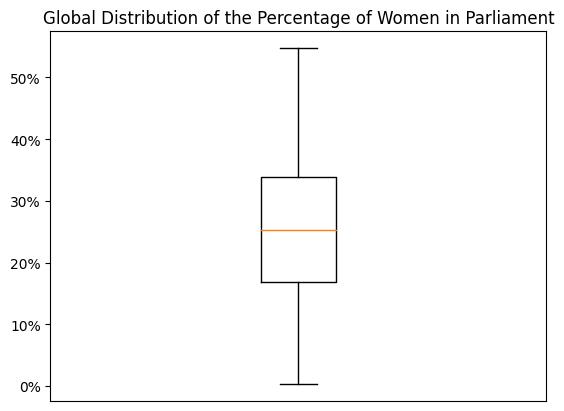

In [120]:
plt.boxplot(women_df['% Women'].dropna())
plt.title('Global Distribution of the Percentage of Women in Parliament')
plt.xticks([])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

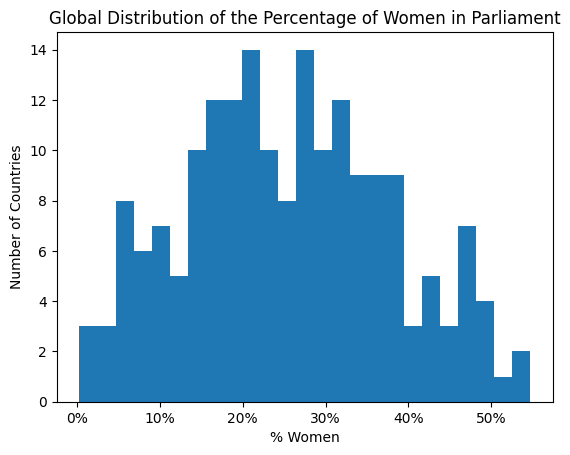

In [109]:
plt.hist(women_df['% Women'],bins=25)
plt.title('Global Distribution of the Percentage of Women in Parliament')
plt.xlabel('% Women')
plt.ylabel('Number of Countries')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

We need to do the same thing for the internet access data, which is available from the [World Bank](https://data.worldbank.org/indicator/IT.NET.USER.ZS?view=map&year=2021). I won't spend as much time describing this, since we've done a lot of it already.

In [123]:
internet_csv = 'API_IT.NET.USER.ZS_DS2_en_csv_v2_5607717.csv'
if not path.exists(internet_csv):
    internet_csv = 'https://raw.githubusercontent.com/am-bean/SummerDoctoralProgram/main/API_IT.NET.USER.ZS_DS2_en_csv_v2_5607717.csv'

internet_df = pd.read_csv(internet_csv,skiprows=4)



Another dangerous conceptual choice. The data is not all up to date through the same year. To simplify things, I am assuming that the most recent year for each line is the value for the present. It might be better to try to pair each year's data with parliamentary data from the same year.

In [124]:
internet_df['% Internet'] = internet_df.max(axis=1,numeric_only=True)

In [125]:
internet_df = internet_df[['Country Name','% Internet']]
internet_df.head()

,Country Name,% Internet
0,Aruba,97.170000
1,Africa Eastern and Southern,27.660654
2,Afghanistan,18.400000
3,Africa Western and Central,46.990497
4,Angola,32.602302


Let's see what the internet data looks like:

In [126]:
print(f'Total Number of Countries: {len(internet_df)}\n')

print(f'Min % Internet: {np.min(internet_df["% Internet"]):.1f}')
print(f'Mean % Internet: {np.mean(internet_df["% Internet"]):.1f}')
print(f'Max % Internet: {np.max(internet_df["% Internet"]):.1f}')

Total Number of Countries: 266

Min % Internet: 0.0
Mean % Internet: 65.6
Max % Internet: 100.0


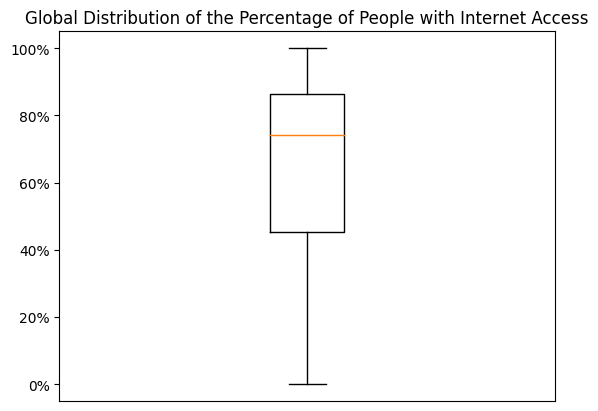

In [127]:
plt.boxplot(internet_df['% Internet'].dropna())
plt.title('Global Distribution of the Percentage of People with Internet Access')
plt.xticks([])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

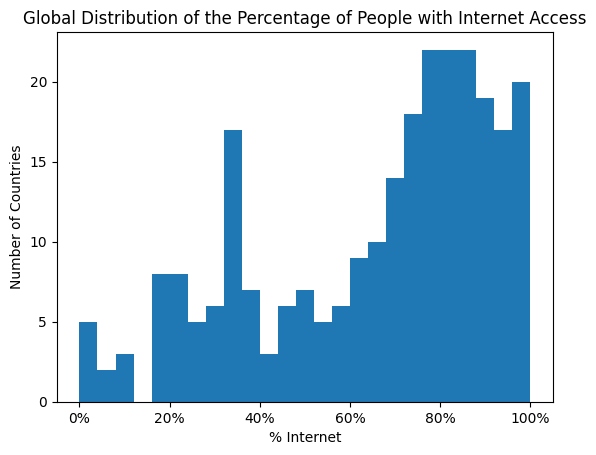

In [128]:
plt.hist(internet_df['% Internet'],bins=25)
plt.title('Global Distribution of the Percentage of People with Internet Access')
plt.xlabel('% Internet')
plt.ylabel('Number of Countries')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

## Data Analysis

The last step is to combine the two dataframes into a larger dataframe based on the shared countries. This is a BIG pain. The country names are not consistent between the two sources, and I had to match them by hand. Rather than write code, I did this in Excel because it was faster. You just get to load the final combined version.

In [130]:
data_csv = 'regression_example.csv'
if not path.exists(data_csv):
    data_csv = 'https://raw.githubusercontent.com/am-bean/SummerDoctoralProgram/main/regression_example.csv'

df = pd.read_csv(data_csv,skiprows=1)

df = df.iloc[:-7,:]
df['%Women'] = df['%Women'].astype(float).copy()
df['%Internet'] = df['%Internet'].astype(float).copy()

In [131]:
df.head()

,Country,%Women,%Internet
0,Rwanda,61.3,30.5
1,Cuba,53.4,71.1
2,Nicaragua,51.7,57.1
3,Mexico,50.0,75.6
4,New Zealand,50.0,95.9


We can make a scatter plot to see if there is a visual relationship. Doesn't seem too promising. Is this a surprise?

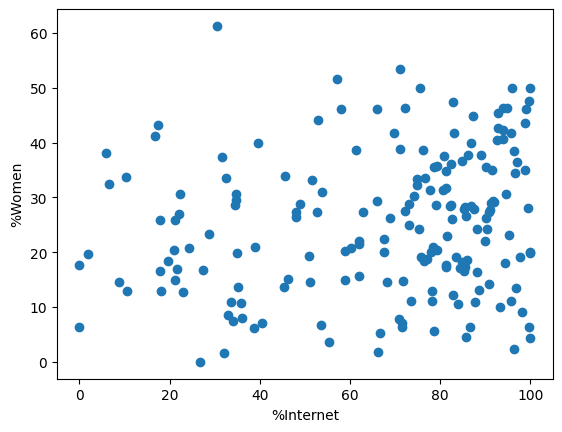

In [132]:
plt.figure()
plt.scatter('%Internet', '%Women', data=df)
plt.xlabel("%Internet")
plt.ylabel("%Women")
plt.show()

Finally, we use statsmodels to fit an OLS regression model. The summary prints out all the relevant details.

In [133]:
my_lm = sm.OLS(df['%Women'],sm.add_constant(df['%Internet'])).fit()
print(my_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 %Women   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     6.292
Date:                Thu, 06 Jul 2023   Prob (F-statistic):             0.0130
Time:                        11:37:36   Log-Likelihood:                -734.51
No. Observations:                 186   AIC:                             1473.
Df Residuals:                     184   BIC:                             1479.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.5782      2.462      7.951      0.0

In order to add a line to the plot, I'm making some dummy data which fits the regression line, then I plot the line over the data.

In [134]:
x = np.linspace(df['%Internet'].min(),df['%Internet'].max(),100)
y = x * my_lm.params['%Internet'] + my_lm.params['const']

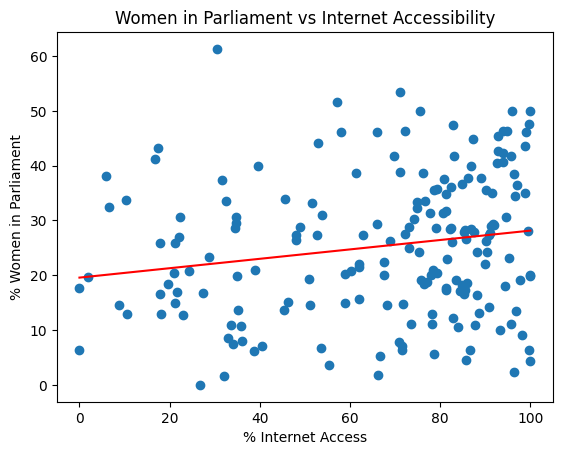

In [135]:
plt.figure()
plt.scatter('%Internet', '%Women', data=df)
plt.plot(x,y, color='red')
plt.xlabel("% Internet Access")
plt.ylabel("% Women in Parliament")
plt.title('Women in Parliament vs Internet Accessibility')
plt.show()

What do you think? How would you interpret these results? What would you do next?